# 01 — EDA + Limpeza Diagnóstica (IBOV)

Neste notebook eu:
1. Leio o CSV baixado pelo `00_get_data.ipynb`
2. Corrijo as colunas (flatten + renomeio para português)
3. Calculo retornos diários
4. Faço checagens básicas de consistência
5. Gero gráficos de fechamento e retornos
6. Salvo `ibov_clean.parquet` em `data/processed/`


In [48]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [52]:
# caminho do CSV baixado via yfinance
root = Path('.').resolve()
raw_csv = root / 'data' / 'raw' / 'ibov_yf.csv'
assert raw_csv.exists(), f'Coloque o CSV em {raw_csv}'

In [ ]:
# leitura inicial (índice na 1ª coluna)
df = pd.read_csv(raw_csv, index_col=0)

In [ ]:
# se vier cabeçalho duplo do yfinance (ex.: ('Close','^BVSP')), relê com header=[0,1] e achata
if isinstance(df.columns, pd.MultiIndex) or any(isinstance(c, tuple) for c in df.columns):
    df = pd.read_csv(raw_csv, header=[0,1], index_col=0)
    df.columns = [c[0] for c in df.columns]  # ('Close','^BVSP') -> 'Close'

In [ ]:
# garantindo índice datetime (alguns CSVs salvam como string)
df.index.name = "Date"
df.index = pd.to_datetime(df.index, errors='coerce')
df = df[~df.index.isna()].sort_index()

C:\Users\mruther\AppData\Local\Temp\ipykernel_21548\3920773359.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')


In [69]:
# renomeando para nosso padrão em PT-BR
rename_map = {
    'Open': 'abertura',
    'High': 'maxima',
    'Low': 'minima',
    'Close': 'ultimo',
    'Adj Close': 'adj_close',
    'Volume': 'vol'
}
df = df.rename(columns={c: rename_map.get(c, c) for c in df.columns})


In [70]:
# garantindo que preços e volume são numéricos
for col in ['ultimo', 'abertura', 'maxima', 'minima', 'vol']:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.replace(' ', '', regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [71]:
# sanity check do carregamento
summary_before = {
    'linhas': int(len(df)),
    'periodo': (df.index.min().strftime('%Y-%m-%d'), df.index.max().strftime('%Y-%m-%d')),
    'nulos': {col:int(df[col].isna().sum()) for col in ['ultimo','abertura','maxima','minima','vol'] if col in df.columns}
}
summary_before

{'linhas': 3891,
 'periodo': ('2010-01-04', '2025-09-12'),
 'nulos': {'ultimo': 0, 'abertura': 0, 'maxima': 0, 'minima': 0, 'vol': 0}}

In [62]:
# calcular retornos diários
df['return_d1'] = df['ultimo'].pct_change()

In [63]:
# sanity check: retornos extremos (> 15%)
mask_ret = df['return_d1'].abs() <= 0.15
print('Linhas totais:', len(df))
print('Falharam retorno >15%:', (~mask_ret).sum())

Linhas totais: 3891
Falharam retorno >15%: 1


In [64]:
# aplicando filtro
df_clean = df[mask_ret].copy()
df_clean['return_d1'] = df_clean['ultimo'].pct_change()
print('Linhas restantes:', len(df_clean))

Linhas restantes: 3890


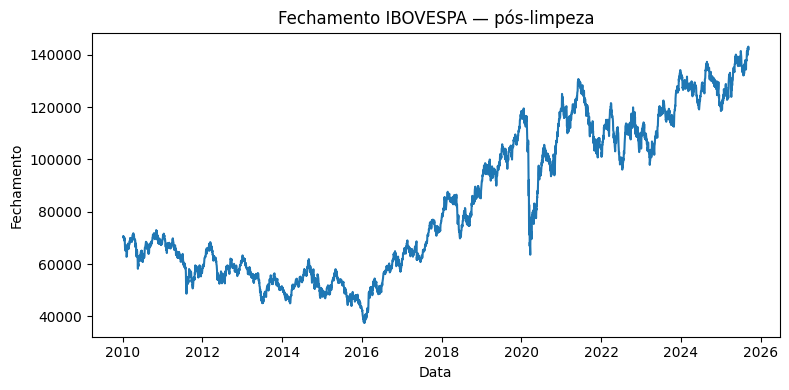

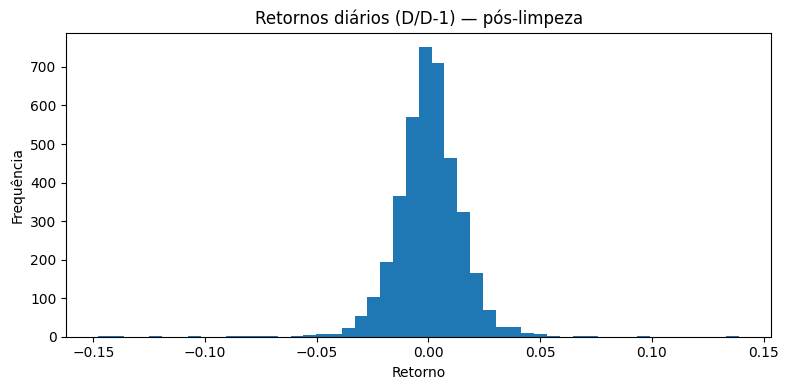

In [67]:
# gráficos
plt.figure(figsize=(8,4))
plt.plot(df_clean.index, df_clean['ultimo'])
plt.title('Fechamento IBOVESPA — pós-limpeza')
plt.xlabel('Data'); plt.ylabel('Fechamento')
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.hist(df_clean['return_d1'].dropna(), bins=50)
plt.title('Retornos diários (D/D-1) — pós-limpeza')
plt.xlabel('Retorno'); plt.ylabel('Frequência')
plt.tight_layout(); plt.show()

In [68]:
# salvar parquet limpo
out_path = root / 'data' / 'processed' / 'ibov_clean.parquet'
out_path.parent.mkdir(parents=True, exist_ok=True)
df_clean.to_parquet(out_path)
str(out_path)

'C:\\Users\\mruther\\Documents\\FIAP\\FASE 2\\postech-challenge2\\notebooks\\data\\processed\\ibov_clean.parquet'